In [460]:
%matplotlib inline
'''
Created on 28 Aug 2018

@author: marta
'''
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os

def read_data_set(filename):
    df = pd.read_csv(filename, header = 0)
    y = df.label.values
    x = df.drop(['label'],axis=1).values
    return x, y

x, y = read_data_set('fashion-mnist_train.csv')
x, y = shuffle(x, y, random_state=0)
testX, testY = read_data_set('fashion-mnist_test.csv')
x, y = shuffle(testX, testY, random_state=0)

def toOneHot(y):
    one_hot = np.zeros((len(y), np.amax(y)+1))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

y = toOneHot(y)
testY = toOneHot(testY)


(10000, 10)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## Display random image

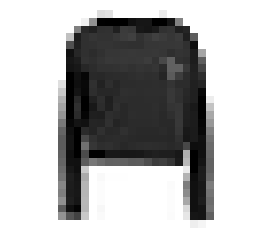

In [430]:
%matplotlib inline
import random
import matplotlib
import matplotlib.pyplot as plt
    
i = random.randint(0, len(x))
plt.imshow(x[i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [431]:
def preprocess(trainX, testX):
    trainX = np.array(trainX, dtype=np.float64)
    trainX -= np.mean(trainX) 
    trainX /= np.std(trainX, axis = 0)
    
    testX = np.array(testX, dtype=np.float64)
    testX -= np.mean(trainX) ## Train centered around test mean
    testX /= np.std(trainX, axis = 0)
    return trainX, testX

x, testX = preprocess(x, testX)


In [434]:
N = 60000
hidden_size = 2**7
input_size = 28 * 28
output_size = 10
# print(x.shape)
# sub_array_x = x[0:1000]
# # print(sub_array.shape)

# sub_array_y = y[0:1000]

# w1 = np.random.uniform(-1,1,(HIDDEN_SIZE, sub_array_x.shape[1]))
# # w1 = addBias(w1)
# print("w1 shape" + str(w1.shape))
# b1 = np.full(sub_array_x.shape[1], 0.01)

# # w2 = np.random.uniform(-1,1,(HIDDEN_SIZE, w1.shape[0]))
# # print("w2 shape" + str(w2.shape))

# b2 = np.full(sub_array_x.shape[1], w1.shape[0])

# # w2 = addBias(w2)

# w2 = np.random.uniform(-1,1,(1, w1.shape[0]))
# # b3 = np.full(sub_array.shape[1], w2.shape[0])
# print("w2 shape" + str(w2.shape))

# # input_range = 1.0 / sub_array_x ** (1/2)
# # output_range = 1.0 / HIDDEN_SIZE ** (1/2)
# w1 = np.random.normal(loc = 0, size = (sub_array_x.shape[1], HIDDEN_SIZE))
# w2 = np.random.normal(loc = 0, size = (w1.shape[0], 1))
std=1e-4
w1 = std * np.random.randn(input_size, hidden_size)
b1 = np.ones(hidden_size)
w2 = std * np.random.randn(hidden_size, output_size)
b2 = np.ones(output_size)


In [ ]:
import math
from sklearn.metrics import accuracy_score

class Activation:
    
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def softmax(x):
        """ Use at output for multiclass problems for probabilities that sum to 1
        """
        x -= np.max(x)
        sm = (np.exp(x).T / np.sum(np.exp(x),axis=1)).T
        return sm
    
class Loss:
    @staticmethod
    def crossEntropy(y, yhat):
        """ Calculate Cost function
            Reference: [4] 
        """
        m = y.shape[1]
        return - 1./m * np.nansum(np.multiply(yhat, safeLog(y)) + np.multiply((1-yhat), safeLog(1-y)))
    
    
def add_dropout(x):
    """ Add dropout
        Reference: [2] 
    """
    P = 0.9
    dropoutMask = (np.random.rand(*x.shape) < P) / P 
    x = x * dropoutMask
    return x

def get_prediction(X, weights, biases):
    weights_1 = weights[0]
    weights_2 = weights[1]
    bias_1 = biases[0]
    bias_2 = biases[1]
    h1 = Activation.relu(X.dot(weights_1) + bias_1)
    y2 = h1.dot(weights_2) + bias_2
    
    y_pred = Activation.softmax(y2)
    return y_pred

def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

def learningRateStepDecay(iteration, initialLearningRate=0.1, iterations_drop=10.0):
    """ Reduce learning rate by half at intervals during training
        Reference: [3] 
    """
    drop = 0.5
    learningRate = initialLearningRate * math.pow(drop,  
           math.floor((1+iteration)/iterations_drop))
    learningRates.append(learningRate)
    return learningRate

def safeLog(x): 
    tiny=1e-12
    x = np.clip(x, tiny, 1. - tiny)
    return np.log(x)
    
costValues = []

def calulate_gradients(X, y, weights, biases, dropout=True):
    """ Calculate the change for the weights matrix
        Reference: [1] 
    """
    """ Calculate predictions for given inputs and current weights
        Reference: [1] 
    """

    W1, b1 = weights[0], biases[0]
    W2, b2 = weights[1], biases[1]
    N, D = X.shape

    y1 = X.dot(W1) + b1 
    h1 = Activation.relu(y1)
    y2 = h1.dot(W2) + b2
    scores = y2
    
    probs = Activation.softmax(scores) 
    dy2 = probs - y
#     print(np.arange(N).shape)
#     print(y.shape)
#     print(dy2.shape)
#     dy2[np.arange(N), y.astype(int)] -= 1
#     delta = a[-1] - Y
#     grads[-1] = a[-2].T.dot(delta)
    
    dy2 = probs - y
    dy2 /= N

    dW2 = h1.T.dot(dy2)
    dh1 = dy2.dot(W2.T)
    dy1 = dh1 * (y1 >= 0)
    dW1 = X.T.dot(dy1)
    db1 = np.sum(dy1, axis=0)
    db2 = np.sum(dy2, axis=0)
    if dropout==True:
        dW1 = add_dropout(dW1)
        dW2 = add_dropout(dW2)
    grads = {}
    grads['W1'] = dW1
    grads['W2'] = dW2
    grads['b1'] = db1
    grads['b2'] = db2
     
    return grads

def accuracy(yhat, y):
#     print('yhat')
#     print(yhat.shape)
#     print('y')
#     print(y.shape)
    yhat_indices = np.argmax(yhat, axis=1)
    y_indices = np.argmax(y, axis=1)
    return accuracy_score(y_indices, yhat_indices)

std=1e-4
train_accs = []
val_accs = []
cost = []
ITERATIONS = 100

#     w1 = std * np.random.randn(input_size, hidden_size)
#     w2 = std * np.random.randn(hidden_size, output_size)

w1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
b1 = np.ones(hidden_size)
w2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
b2 = np.ones(output_size)

#     print("x shape")
#     print(x.shape)
#     print("w1 shape")
#     print(w1.shape)
#     print("b1 shape")
#     print(b1.shape)
#     print("w2 shape")
#     print(w2.shape)
#     print("b2 shape")
#     print(b2.shape)

for i in range(ITERATIONS):
    learning_rate = learningRateStepDecay(i, 0.001, ITERATIONS/10)
#     learning_rate = 0.0001
    gradients = calulate_gradients(x, y, weights=[w1, w2], biases=[b1, b2], dropout=False)
    predicted_y_train = get_prediction(x, weights=[w1, w2], biases=[b1, b2])
    cost.append(Loss.crossEntropy(y, predicted_y_train))    

    train_acc = accuracy(predicted_y_train, y)
    train_accs.append(train_acc)
    predicted_y_test = get_prediction(testX, weights=[w1, w2], biases=[b1, b2])
    val_acc = accuracy(predicted_y_test, testY)
    val_accs.append(val_acc)

    w1 += -learning_rate * gradients['W1']
    w2 += -learning_rate * gradients['W2']
    b1 += -learning_rate * gradients['b1']
    b2 += -learning_rate * gradients['b2']  


/Users/scottcondron/anaconda3/envs/lab1/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [ ]:
plt.plot(train_accs)
plt.ylabel('Training Accuracy')
plt.xlabel('Iterations')
plt.show()

plt.plot(val_accs)
plt.ylabel('Validation Accuracy')
plt.xlabel('Iterations')
plt.show()

plt.plot(cost)
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.show()

In [503]:
import random
predicted_y_test = get_prediction(testX,  weights=[w1, w2], biases=[b1, b2])
i = random.randint(0,len(predicted_y_test))
print(predicted_y_train[i].astype(int))
print(y[i])


[0 0 0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [501]:
print(train_accs)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [462]:
def feed_forward(X, weights):
    a = [X]
    for w in weights:
        a.append(np.maximum(a[-1].dot(w),0))
    return a

def grads(X, Y, weights):
    grads = np.empty_like(weights)
    a = feed_forward(X, weights)
    delta = a[-1] - Y
    grads[-1] = a[-2].T.dot(delta)
    for i in range(len(a)-2, 0, -1):
        delta = (a[i] > 0) * delta.dot(weights[i].T)
        grads[i-1] = a[i-1].T.dot(delta)
    return grads / len(X)

trX, trY, teX, teY = x, y, testX, testY
weights = [np.random.randn(*w) * 0.1 for w in [(784, 100), (100, 10)]]
num_epochs, batch_size, learn_rate = 30, 20, 0.1

for i in range(num_epochs):
    for j in range(0, len(trX), batch_size):
        X, Y = trX[j:j+batch_size], trY[j:j+batch_size]
        weights -= learn_rate * grads(X, Y, weights)
    prediction = np.argmax(feed_forward(teX, weights)[-1], axis=1)
    print(np.mean(prediction == np.argmax(teY, axis=1)))

0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


KeyboardInterrupt: 

In [ ]:
print(predicted_y_test)

In [395]:
predicted_y_train = get_prediction(x, weights=[w1, w2], biases=[b1, b2])
print(w1)

[[ 8.20006273e-05  5.51227101e-05 -7.13671025e-05 ... -6.25317452e-05
   7.34813266e-05 -6.98233164e-06]
 [-1.60606121e-04  1.45481656e-04  1.21157668e-08 ... -1.49475389e-04
  -2.26472545e-05  4.85230347e-05]
 [ 7.40697189e-05 -3.03574552e-05  1.24732297e-05 ... -9.96223004e-05
   1.05652796e-04  1.09940577e-04]
 ...
 [ 5.28749682e-06  1.87267118e-04 -6.99443848e-05 ... -1.21327609e-04
  -2.81142500e-05  3.03499805e-05]
 [-2.59685694e-04  2.29576253e-05 -1.88557157e-06 ... -1.83677396e-05
  -5.72328197e-05  1.00189172e-05]
 [-6.12490408e-05  8.36907408e-05  7.43009015e-05 ...  7.06306897e-06
   5.75937617e-06 -3.14877505e-06]]


In [396]:
print(w2)

[[ 2.05038611e-05  3.33230759e-05  1.05421261e-04 ... -1.21285472e-04
   8.04238962e-05  1.77135813e-05]
 [ 2.19874047e-04  1.08808164e-04 -1.36731900e-04 ... -8.17413224e-05
  -5.02157509e-05 -1.41387251e-04]
 [ 1.28948834e-04  3.14556474e-05 -8.55123425e-06 ... -2.14793246e-04
  -1.00085555e-05 -9.41217300e-05]
 ...
 [-1.77511418e-04 -1.72446441e-04  1.80315455e-04 ... -6.49584907e-05
   3.39001722e-05  1.39490750e-04]
 [ 2.77109686e-05 -1.04953626e-04  7.61662135e-05 ... -8.07443725e-05
  -9.42005603e-05 -1.04670979e-04]
 [ 1.88806933e-04  5.46938034e-05  1.70116766e-06 ... -1.20646048e-04
  -1.26735729e-04  4.31524548e-05]]


In [515]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )